# U-STEMist Group : TomorrowLand Project

## Abstract


As mentioned in our group proposal, we plan to combine the cutting-edge technology to improve the rubbish classification and control the C&D Waste  in construction site.  Hence, we suggest that building a AI-based trashbin to put these rubbish at the correct places. Obviously, the core part is how to classify the rubbish with high accuracy, just like the human eyes. That's to say, how to train a nice AI model to do this job? That's we are going to demostrate!
  


## Keyword
- Transfer Learning [why transfer learning?](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)
- Image Classification by CNN Deep Learning

## Environment
- Python 3.6
- Google TensorFlow Version: 1.13.0
- Google Colaboratory with Runtime Hardware Accelerator: GPU

## Materials
  - Pre-trained Model : [MobileNet V2](https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/2) (with trained on ImageNet) 
   - MobileNet V2 is a family of neural network architectures for efficient on-device image classification and related tasks
  - Dataset in our Google Drive, path: ./Team Drive/dataset/train

## Preparation

Install Python packages and import them 

In [0]:

from __future__ import absolute_import, division, print_function
# image visualize and plot
import numpy as np
import matplotlib.pylab as plt
# deep learning components
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.backend as K
from tensorflow.keras import layers, optimizers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# check tensorflow version
tf.VERSION

W0605 03:25:25.843238 140624205268864 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


'1.13.1'

First of all, setting up connections to our Google Drive so that we could load dataset via cloud disk mount

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# export the directory
!ls gdrive/Team\ Drives/'2018-2019 U-STEMist Group 21 (Tomorrowland)'/Dataset/

test  train  validation


### Setup: pre-train Model and dataset

- Simple transfer learning : Using `tf.hub`,  it is simple to retrain the **top** layer of the model to recognize the classes in our dataset.

- TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/2" 

def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

IMAGE_SIZE

Instructions for updating:
Colocations handled automatically by placer.


W0605 03:27:02.729889 140624205268864 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


[224, 224]

### Data Augmentation 
Problem: Only hundreds of images per class to train a CNN model, how to enlarge our dataset without shooting more images manually?

TensorFlow Keras API provide `ImageDataGenerator` to generate batches of tensor image data with real-time data augmentation. 

The data will be looped over (in batches). 

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        directory = r"/content/gdrive/Team Drives/2018-2019 U-STEMist Group 21 (Tomorrowland)/Dataset/train",
        target_size=IMAGE_SIZE, # (224,224)
        batch_size=32,
        color_mode="rgb",
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        directory = r"/content/gdrive/Team Drives/2018-2019 U-STEMist Group 21 (Tomorrowland)/Dataset/test",
        target_size=IMAGE_SIZE, # (224,224)
        batch_size=32,
        color_mode="rgb",
        class_mode='categorical')

Found 2276 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


Ensure the data generator is generating images of the expected size:

In [0]:
for image_batch,label_batch in train_generator:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


Wrap the module in a keras layer.

In [0]:
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [0]:
features_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [0]:
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(train_generator.num_classes, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0605 03:27:32.849462 140624205268864 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 8965      
Total params: 8,965
Trainable params: 8,965
Non-trainable params: 0
_________________________________________________________________


Initialize the TFHub module and check the result

In [0]:
sess =  K.get_session()
init = tf.global_variables_initializer()
sess.run(init)

result = model.predict(image_batch)
result.shape

(32, 5)

## Model Training and Evaluation

### Optimizer, Loss function and Metrics

In [0]:
#sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
  optimizer= tf.train.AdamOptimizer(), #sgd
  loss='categorical_crossentropy',
  metrics=['accuracy'])

Now use the `.fit` method to train the model.

To keep this example short train just a single epoch. To visualize the training progress during that epoch, use a custom callback to log the loss and accuract of each batch.

In [0]:

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    
batch_stats = CollectBatchStats()

"""
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=32,
                         write_images=True)
"""
steps_per_epoch = train_generator.samples//train_generator.batch_size

#for item in train_generator:
model.fit(train_generator, 
          epochs=25, 
          steps_per_epoch=steps_per_epoch,
          verbose=1,
          validation_split=0.2,
          #callbacks = [tbCallBack])
          callbacks = [batch_stats])

Instructions for updating:
Use tf.cast instead.


W0605 03:28:31.915923 140624205268864 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/30
72/72 [==============================] - 1442s 20s/step - loss: 0.7338 - acc: 0.7087
Epoch 2/30
72/72 [==============================] - 11s 156ms/step - loss: 0.3365 - acc: 0.8880
Epoch 3/30
72/72 [==============================] - 11s 155ms/step - loss: 0.2615 - acc: 0.9152
Epoch 4/30
72/72 [==============================] - 11s 154ms/step - loss: 0.2122 - acc: 0.9359
Epoch 5/30
72/72 [==============================] - 11s 157ms/step - loss: 0.1700 - acc: 0.9521
Epoch 6/30
72/72 [==============================] - 11s 155ms/step - loss: 0.1518 - acc: 0.9649
Epoch 7/30
72/72 [==============================] - 11s 156ms/step - loss: 0.1242 - acc: 0.9767
Epoch 8/30
72/72 [==============================] - 11s 154ms/step - loss: 0.1124 - acc: 0.9811
Epoch 9/30
72/72 [==============================] - 11s 156ms/step - loss: 0.0930 - acc: 0.9846
Epoch 10/30
72/72 [==============================] - 11s 158ms/step - loss: 0.0847 - acc: 0.9908
Epoch 11/30
72/72 [====================

**Remark**:  the results of model prediction still depends a lot on the feeding dataset. If not optimal, the quality of dataset should be improved.  

### Training Summary Visualization
Accuracy VS Loss

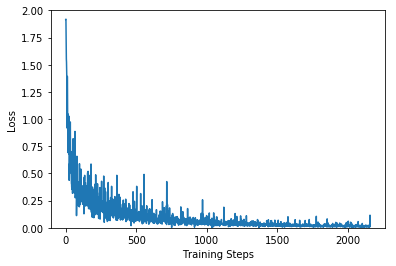

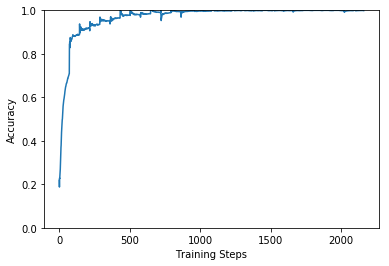

In [0]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

### Image Batch Evaluation and visualization

20 pictures from test dat

In [0]:
label_names = sorted(test_generator.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic'], dtype='<U9')

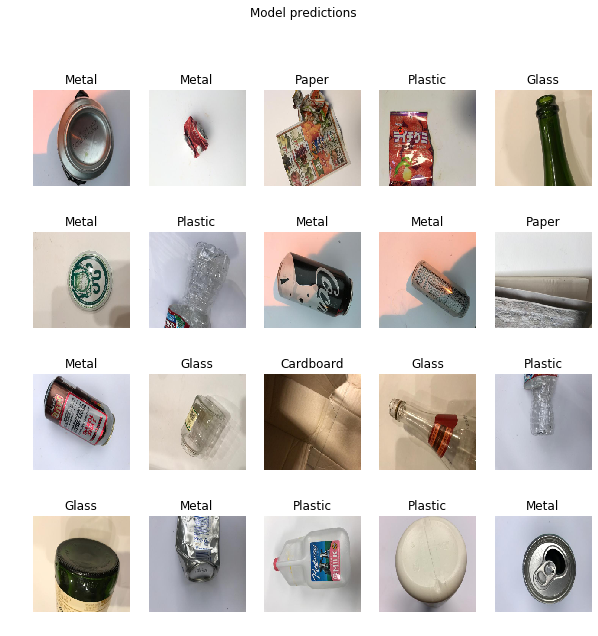

In [0]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]

plt.figure(figsize=(10,10))
for n in range(20):
  plt.subplot(4,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Model Export 

A Convelutional Neuron Network (CNN) for multi-class image classification is Done.

In [0]:
# Save entire model to a HDF5 file
model.save('./gdrive/Team Drives/2018-2019 U-STEMist Group 21 (Tomorrowland)/saved_models/my_model.h5')

## Enhancement


1.   More Input: More original images about C&D Waste
2.   Better network structure and parameters optimizations



## Reference
1. TensorFlow Hub [link](https://medium.com/tensorflow/introducing-tensorflow-hub-a-library-for-reusable-machine-learning-modules-in-tensorflow-cdee41fa18f9)

TensorFlow Hub is a platform to publish, discover, and reuse parts of machine learning modules in TensorFlow. By a module, we mean a self-contained piece of a TensorFlow graph, along with its weights, that can be reused across other, similar tasks. By reusing a module, a developer can train a model using a smaller dataset, improve generalization, or simply speed up training.

2. How to Retrain an Image Classifier for New Categories [link](https://www.tensorflow.org/hub/tutorials/image_retraining#visualizing_the_retraining_with_tensorboard) 

For this guide, it demonstrated a possible way to retrian an Image Classifier involved with a modern technique called 'transfer learning', which is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

3. Building powerfel image classification model using very little data [link](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

In this tutorial, we will present a few simple yet effective methods that you can use to build a powerful image classifier, using only very few training examples --just a few hundred or thousand pictures from each class you want to be able to recognize.

4. Hub with Keras [link](https://www.tensorflow.org/tutorials/images/hub_with_keras#dataset)

This tutorial demonstrates:
  - How to use TensorFlow Hub with tf.keras.
  - How to do image classification using TensorFlow Hub.
  - **How to do simple transfer learning.**

## Update Log

- complete the first version, date: 2019/4/3；acc = 0.97
- update pre-trained model ResNet40 -> MobileNetV2, date: 2019/4/11; acc=0.9991
- 2019/06/05: update model saver to output three essential files: .meta + .index + .data-00000-of-00001 for TF model -> HS Graph model